In [98]:
import os

import numpy as np
import qiskit.ignis.mitigation.measurement as mc
from dotenv import load_dotenv
from numpy import pi
from qiskit import (IBMQ, ClassicalRegister, QuantumCircuit, QuantumRegister,
                    transpile)
from qiskit.ignis.verification.tomography import (StateTomographyFitter,
                                                  state_tomography_circuits)
from qiskit.providers.aer import AerSimulator, noise
from qiskit.providers.ibmq.managed import IBMQJobManager
from qutip import Bloch, Bloch3d, Qobj

from sync_gates import add_tomography
from sync_calcs import dm2bloch

load_dotenv()

# IBMQ.ibmq.save_account(os.environ['TOKEN'], overwrite=True)

True

In [99]:
# IBMQ.load_account()

In [100]:
provider = IBMQ.get_provider(group='open', project='main')

job_manager = IBMQJobManager()

backend = provider.get_backend('ibmq_santiago') # Real - ibmq_santiago seems to have the lowest CNOT noise
# backend = provider.get_backend('ibmqx2')
# backend = AerSimulator.from_backend(backend) # Noisy Sim
# backend = AerSimulator() # Ideal Sim

is_real_device = not backend.name().startswith('aer_simulator')

max_shots = backend.configuration().to_dict()["max_shots"]
max_shots

8192

# Parameters

In [101]:
# Simulation Steps
SIM_STEPS = 16
SHOTS = 8192

gain_amp = 0.1
loss_amp = 1
m = min(loss_amp, gain_amp)

detuning = 5 * 3 * m
signal_strength = 5 * 2 * m
# dt = (np.logspace(0.1, 1, SIM_STEPS, endpoint=True)) / 10
dt = 0.2


# Circuit

In [102]:
def generate_circuit(time_steps, detuning, signal_strength, steps):
    qreg_q = QuantumRegister(2, "q")
    creg_c = ClassicalRegister(1, "c")

    qc = QuantumCircuit(qreg_q, creg_c)

    for i in range(steps):
        if hasattr(time_steps, '__iter__'):
            dt = time_steps[i]
        else:
            dt = time_steps
        theta_d = 2 * np.arcsin(np.sqrt(loss_amp * dt))
        theta_g = 2 * np.arcsin(np.sqrt(gain_amp * dt))

        theta = signal_strength * dt
        phi = pi - detuning * dt / 2
        lam = pi - detuning * dt / 2

        qc.u(theta, phi, lam, qreg_q[0])

        # Loss CU
        # qc.cu(theta_d, 0, 0, 0, qreg_q[0], qreg_q[1])
        # qc.cx(qreg_q[1], qreg_q[0])
        # qc.measure(qreg_q[1], creg_c[0])
        # qc.reset(qreg_q[1])

        # Loss 2xCX
        # qc.u(pi / 2, -pi, 0, qreg_q[0])
        # qc.u(-theta_d / 2, -pi / 2, pi, qreg_q[1])
        # qc.cx(qreg_q[1], qreg_q[0])
        # qc.u(pi / 2, -pi / 2, 0, qreg_q[0])
        # qc.u(-theta_d / 2, pi, pi / 2, qreg_q[1])
        # qc.cx(qreg_q[1], qreg_q[0])
        # qc.u(0, 0, -pi/2, qreg_q[0])
        # qc.u(0, 0, -pi/2, qreg_q[1])
        # qc.measure(qreg_q[1], creg_c[0])
        # qc.reset(qreg_q[1])

        # # Gain
        # qc.u(-pi, 0, 0, qreg_q[0])
        # qc.cx(qreg_q[0], qreg_q[1])
        # qc.cu(theta_g, 0, 0, 0, qreg_q[0], qreg_q[1])
        # qc.cx(qreg_q[0], qreg_q[1])
        # qc.u(pi, 0, 0, qreg_q[0])
        # qc.measure(qreg_q[1], creg_c[0])
        # qc.reset(qreg_q[1])

    return qc


# Tomography

In [103]:
circuits = [generate_circuit(dt, detuning, signal_strength, i) for i in range(0, SIM_STEPS + 1)]

circuits_with_tomo = [list(add_tomography(circuit)) for circuit in circuits]

compiled_circuits_with_tomo = [transpile(circuit, backend) for circuit in circuits_with_tomo]

# Calibration

In [104]:
measurement_calibration_circuit, state_labels = mc.complete_meas_cal(qubit_list=[0])

if is_real_device:
    calibration_job = job_manager.run(measurement_calibration_circuit, backend=backend, name="QSync_calibration")
    result = calibration_job.results().combine_results()
else:
    calibration_job = backend.run(measurement_calibration_circuit, shots=SHOTS)
    result = calibration_job.result()

measurement_calibration_fitter = mc.CompleteMeasFitter(result, state_labels)
measurement_calibration_fitter.cal_matrix

array([[0.98925781, 0.02832031],
       [0.01074219, 0.97167969]])

In [105]:
if not is_real_device:
    jobs = [backend.run(circuit, name=f"QSync_{i}", shots=SHOTS) for i, circuit in enumerate(compiled_circuits_with_tomo)]
else:
    jobs = [job_manager.run(circuit, backend=backend, name=f"QSync_{i}", shots=SHOTS) for i, circuit in enumerate(compiled_circuits_with_tomo)]

In [106]:
uncorrected_states = []

for job, circuit in zip(jobs, compiled_circuits_with_tomo):
    if not is_real_device:
        result = job.result()
    else:
        result = job.results().combine_results()

    tomo_state = StateTomographyFitter(result, circuit)
    state = tomo_state.fit(method="lstsq")

    uncorrected_states.append(state)


managedjob._async_submit:WARNING:2021-05-13 17:28:03,774: Job limit reached, waiting for job 609d5393df1fcb7b3aadf3fa to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-13 17:28:03,935: Job limit reached, waiting for job 609d5393df1fcb7b3aadf3fa to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-13 17:28:03,954: Job limit reached, waiting for job 609d5393df1fcb7b3aadf3fa to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-13 17:28:04,016: Job limit reached, waiting for job 609d5393df1fcb7b3aadf3fa to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-13 17:28:04,017: Job limit reached, waiting for job 609d5393df1fcb7b3aadf3fa to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05-13 17:28:04,074: Job limit reached, waiting for job 609d5393df1fcb7b3aadf3fa to finish before submitting the next one.
managedjob._async_submit:WARNING:2021-05

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.95776367+0.j         0.17626953-0.07775879j]
 [0.17626953+0.07775879j 0.04223633+0.j        ]]

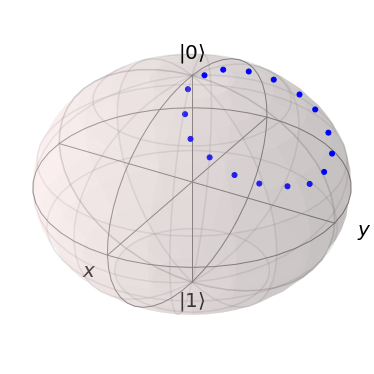

In [107]:
b = Bloch()
points = dm2bloch([Qobj(s) for s in uncorrected_states])
b.add_points(points, meth="s")

# b.view = [0, 90]
b.show()
Qobj(uncorrected_states[-1])

In [108]:
if is_real_device:
    # Save job ids for later retrieval
    name = input("Jobs File Name: ")

    with open(f"{name}.txt", "w") as f:
        f.write("Calibration:\n")
        f.write(f"{calibration_job.job_set_id()}\n")
        f.write("\n")
        f.write("Simulation:\n")
        for job in jobs:
            id_ = job.job_set_id()
            f.write(f"{id_}\n")

In [109]:
corrected_states = []

for job, circuit in zip(jobs, compiled_circuits_with_tomo):
    if not is_real_device:
        result = job.result()
    else:
        result = job.results().combine_results()

    corrected_result = measurement_calibration_fitter.filter.apply(result, method="least_squares")
    mitigated_tomo_state = StateTomographyFitter(corrected_result, circuit)
    state = mitigated_tomo_state.fit(method="lstsq")

    corrected_states.append(state)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.96368936+0.j         0.17296949-0.07123015j]
 [0.17296949+0.07123015j 0.03631064+0.j        ]]

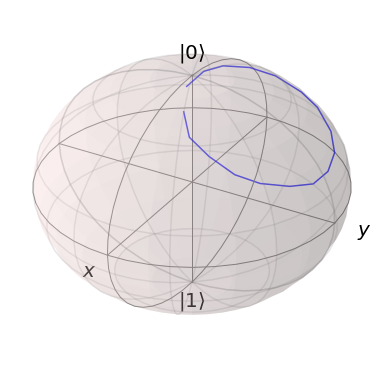

In [110]:
b = Bloch()
points = dm2bloch([Qobj(s) for s in corrected_states][:60])
b.add_points(points, meth="l")
# b.add_points(points, meth="s")
# b.view = [0, 90]
b.show()
Qobj(corrected_states[-1])

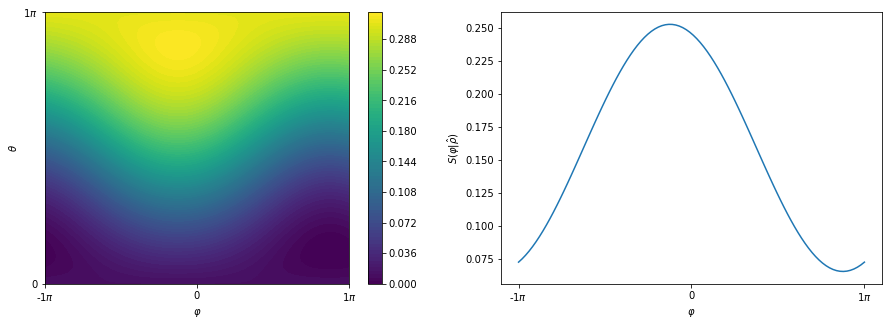

In [111]:
from sync_plots import calc_and_plot_Q_and_S
ss = corrected_states[-1]
calc_and_plot_Q_and_S(Qobj(ss), method="qutip")

In [112]:
if is_real_device:
    # Save job ids for later retrieval
    name = input("Data File Name: ")
    np.save(f'{name}.npy', corrected_states)